In [23]:
import numpy as np 
import matplotlib.pyplot as plt
from numpy.random import default_rng
rng = default_rng()
%matplotlib inline


import torch
from torch import nn
from torch import optim
import numpy as np
from numpy.random import default_rng
rng = default_rng()

In [24]:
### Paramètres : 
T = 1    # Maturité en années
r = 0 # Taux d'intérêt sans risque
N = 10  # Nombre de pas
dt = T / N  # Intervalle de temps
M = int(2**10) # Nombre de chemins MC

lambda_ = 0.05 # paramètre de régularisation


g = lambda x : x # payoff function
R = lambda x : x-x*np.log(x) # Regularization function

In [25]:
def generate_brownian_paths( N, M):
 
    dt = T / N  # Pas de temps
    t = np.linspace(0, T, N+1)  # Discrétisation temporelle
    dW = np.sqrt(dt) * np.random.randn(M, N)  # Incréments brownien
    W = np.zeros((M, N+1))  
    W[:, 1:] = np.cumsum(dW, axis=1)  # Construction des trajectoires

    return  W

In [50]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

def Phi_NN(N,lr = 0.001) :

    class NeuralNetwork(nn.Module):
        def __init__(self):
            super().__init__()
            self.linear_relu_stack = nn.Sequential(
                nn.Linear(1, 21),
                nn.ReLU(),
                nn.Linear(21, 21),
                nn.ReLU(),
                nn.Linear(21, 1),
                nn.LeakyReLU(negative_slope=0.01)
            )

        def forward(self, x):
            out = self.linear_relu_stack(x)
            return out  
        

    # Define the optimizers and the networks : 

    Phi_functions = [NeuralNetwork().to(device) for n in range(1,N)]

    optimizers = [optim.Adam(Phi_functions[n-1].parameters(), lr) for n in range(1,N)]

    return Phi_functions,optimizers

creterio  = nn.MSELoss()

Using cuda device


In [104]:
def train_evaluate(n_iteration,lambda_,Phi_functions,optimizers,data_train):


    Losses = []
    pi_values = np.ones_like(data_train)
    P = []

    for n in range(n_iteration): 

        S_samples = generate_brownian_paths(N-1,M)
        #S_samples = data_train.copy()
        V_values = np.zeros_like(S_samples)
        V_values[:,-1] = g(S_samples[:,-1])


        print(f'{n+1} Iteration ...')
        

        total_loss = 0
        for l in range(N-2,-1,-1):
            
        
            #Calculate the TD-error :
            
            ## construct target vector
            X = S_samples[:,l]
            Y = g(S_samples[:,l])*pi_values[:,l]*dt + lambda_*R(pi_values[:,l])*dt+np.exp(-r*dt)*V_values[:,l+1]*(1-pi_values[:,l]*dt)

            xx = torch.tensor(X, dtype=torch.float32, device=device).reshape(-1, 1)
            yy = torch.tensor(Y, dtype=torch.float32, device=device)

            #print(f"Start training V_{l} ...")
            # entrainement "one step Gadient descent" :
            prediction = Phi_functions[l](xx)
            loss = creterio(prediction, yy.reshape(-1, 1))
            optimizers[l].zero_grad()
            loss.backward()
            optimizers[l].step()
            #print(f"model trained ! ...")
            total_loss+=loss

            # Calculate the new V using the updated parameters 
            with torch.no_grad():
                new_y =Phi_functions[l](xx).cpu().numpy().flatten()
            
            V_values[:,l] = new_y
        

        pi_values = np.ones_like(S_samples)
        pi_values[:,:-1] = np.exp(np.clip(-(V_values[:,:-1]-g(S_samples[:,:-1])) / lambda_, -10, 10))

        if n % 5 == 0 :

            S_samples = generate_brownian_paths(N-1,2**18)
            price,_ = calculate_price(Phi_functions,S_samples)
            P.append(price)


        print(f"Epochs {n+1} finished !")
        print(f"TOTAL LOSS : {total_loss/N}")
        Losses.append((total_loss/N).detach().cpu().numpy())


    return P


def payoff_phi(x): 
    return  x


def calculate_price(Phi_functions,data_train):

    payoffs = np.empty_like(data_train)
    for n in range(0, N):

        payoffs[:,n] = payoff_phi(data_train[:,n])
    
    payoff_opt = payoffs[:,-1].copy() # Payoffs optimaux à l'instant t = N

    for n in range(N-1,0,-1):

        xx = torch.tensor(data_train[:, n], dtype=torch.float32, device=device).reshape(-1, 1)
        with torch.no_grad():
                continuation_function = Phi_functions[n-1](xx).cpu().numpy().flatten()

        stop_at_n = payoffs[:,n] >= continuation_function
        payoff_opt[stop_at_n] = payoffs[stop_at_n,n].copy() # Payoffs optimaux à l'instant t = n


   

    payoff_opt.mean()
    

    return payoff_opt.mean(),payoff_opt

In [124]:
Phi_functions,optimizers = Phi_NN(N)
n_iteration = 1000
S_samples = generate_brownian_paths(N-1,M)
evaluation = train_evaluate(n_iteration,1,Phi_functions,optimizers,S_samples)

1 Iteration ...
Epochs 1 finished !
TOTAL LOSS : 0.1129700094461441
2 Iteration ...
Epochs 2 finished !
TOTAL LOSS : 0.12162797898054123
3 Iteration ...
Epochs 3 finished !
TOTAL LOSS : 0.10891517251729965
4 Iteration ...
Epochs 4 finished !
TOTAL LOSS : 0.1313028335571289
5 Iteration ...
Epochs 5 finished !
TOTAL LOSS : 0.13058307766914368
6 Iteration ...
Epochs 6 finished !
TOTAL LOSS : 0.12469682842493057
7 Iteration ...
Epochs 7 finished !
TOTAL LOSS : 0.11846040934324265
8 Iteration ...
Epochs 8 finished !
TOTAL LOSS : 0.12017112970352173
9 Iteration ...
Epochs 9 finished !
TOTAL LOSS : 0.11598342657089233
10 Iteration ...
Epochs 10 finished !
TOTAL LOSS : 0.10862638801336288
11 Iteration ...
Epochs 11 finished !
TOTAL LOSS : 0.10310973972082138
12 Iteration ...
Epochs 12 finished !
TOTAL LOSS : 0.09907779842615128
13 Iteration ...
Epochs 13 finished !
TOTAL LOSS : 0.11448748409748077
14 Iteration ...
Epochs 14 finished !
TOTAL LOSS : 0.11266038566827774
15 Iteration ...
Epochs 15

In [163]:
from scipy import stats
S_samples = generate_brownian_paths(N-1,2**20)
price,list_price = calculate_price(Phi_functions,S_samples)


sample = list_price
mean = np.mean(sample)
var = np.var(sample, ddof=1)
alpha = 1 - 0.9 
quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
ci_size = quantile * np.sqrt(var / sample.size)
result = { 'mean': mean, 'var': var, 
            'lower': mean - ci_size, 
            'upper': mean + ci_size }

print(result)

{'mean': 0.0006114248217288676, 'var': 0.9769181176778143, 'lower': -0.0009762310801377664, 'upper': 0.0021990807235955016}


In [ ]:
from scipy import stats
Phi_functions,optimizers = Phi_NN(N)

S_samples = generate_brownian_paths(N-1,2**20)
price,list_price = calculate_price(Phi_functions,S_samples)


sample = list_price
mean = np.mean(sample)
var = np.var(sample, ddof=1)
alpha = 1 - 0.9 
quantile = stats.norm.ppf(1 - alpha/2)  # fonction quantile 
ci_size = quantile * np.sqrt(var / sample.size)
result = { 'mean': mean, 'var': var, 
            'lower': mean - ci_size, 
            'upper': mean + ci_size }

print(result)

In [95]:
S_samples = generate_brownian_paths(N-1,2**18)
Phi_functions,optimizers = Phi_NN(N)

calculate_price(Phi_functions,S_samples)

-0.0008874564661661764

In [94]:
lambda_values = [10,1,0.05,0.005]
D = {}
n_iteration = 1500
for lambda_ in lambda_values : 

    Phi_functions,optimizers = Phi_NN(N)
    S_samples = generate_brownian_paths(N-1,M)
    P = train_evaluate(n_iteration,lambda_,Phi_functions,optimizers,S_samples)
    D[lambda_] = P

1 Iteration ...
Epochs 1 finished !
TOTAL LOSS : 1.0044978857040405
2 Iteration ...
Epochs 2 finished !
TOTAL LOSS : 1.0025449991226196
3 Iteration ...
Epochs 3 finished !
TOTAL LOSS : 1.00397527217865
4 Iteration ...
Epochs 4 finished !
TOTAL LOSS : 1.0080034732818604
5 Iteration ...
Epochs 5 finished !
TOTAL LOSS : 1.001384973526001
6 Iteration ...
Epochs 6 finished !
TOTAL LOSS : 0.9889944195747375
7 Iteration ...
Epochs 7 finished !
TOTAL LOSS : 0.9820166826248169
8 Iteration ...
Epochs 8 finished !
TOTAL LOSS : 0.9859977960586548
9 Iteration ...
Epochs 9 finished !
TOTAL LOSS : 0.9880485534667969
10 Iteration ...
Epochs 10 finished !
TOTAL LOSS : 0.9784367680549622
11 Iteration ...
Epochs 11 finished !
TOTAL LOSS : 0.9681663513183594
12 Iteration ...
Epochs 12 finished !
TOTAL LOSS : 0.9718964695930481
13 Iteration ...
Epochs 13 finished !
TOTAL LOSS : 0.9937507510185242
14 Iteration ...
Epochs 14 finished !
TOTAL LOSS : 0.9729080200195312
15 Iteration ...
Epochs 15 finished !
TOT

Text(0, 0.5, 'Relative error')

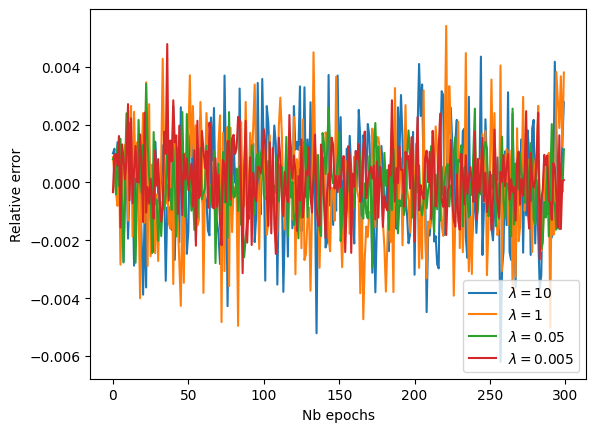

In [96]:
for lambda_ in lambda_values : 

    plt.plot(D[lambda_][:300],label = '$\lambda =$'+str(lambda_))

plt.legend()

plt.xlabel('Nb epochs')
plt.ylabel('Relative error')